In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import mnist
from keras.models import Model
import cv2

In [ ]:
nl = 1
abn = 7
(x_train, y_train), (x_test, y_test) = mnist.load_data()
normal_data = x_train[y_train == nl]
normal_labels = y_train[y_train == nl]
test_data = x_test[(y_test == abn) | (y_test == nl)]
test_labels = y_test[(y_test == abn) | (y_test == nl)]
test_labels_T_F = np.where(test_labels == nl, True, False)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
normal_data.shape, test_data.shape, test_labels.shape

((6742, 28, 28), (2163, 28, 28), (2163,))

In [ ]:
normal_labels[0:20], test_labels[0:20]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=uint8),
 array([7, 1, 1, 1, 7, 7, 1, 1, 7, 7, 1, 1, 1, 7, 1, 1, 7, 7, 7, 1],
       dtype=uint8))

In [ ]:
normal_data = normal_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

In [ ]:
normal_test_data = test_data[test_labels == nl]
abnormal_test_data = test_data[test_labels == abn]

In [ ]:
normal_test_data.shape, abnormal_test_data.shape

((1135, 28, 28), (1028, 28, 28))

In [ ]:
normal_test_labels = test_labels[test_labels == nl]
abnormal_test_labels = test_labels[test_labels == abn]
normal_test_labels[0:20], abnormal_test_labels[0:20]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=uint8),
 array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       dtype=uint8))

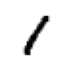

In [ ]:
# First normal digit
plt.figure(figsize=(1,1))
plt.imshow(normal_data[0], cmap="binary")
plt.axis('off')
plt.show()

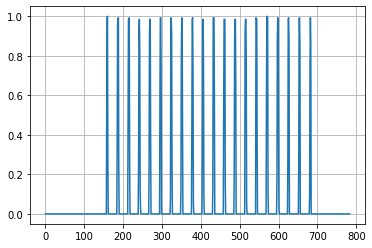

In [ ]:
# 1 dim plot of (flattened array of) first normal digit
plt.grid()
plt.plot(np.arange(28*28), normal_data[0].ravel())
plt.show()

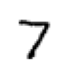

In [ ]:
# first test digit
plt.figure(figsize=(1,1))
plt.imshow(test_data[0], cmap="binary")
plt.axis('off')
plt.show()

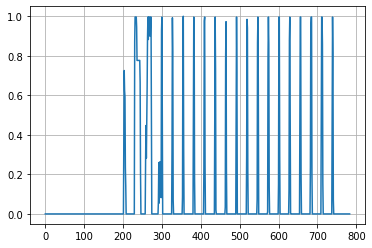

In [ ]:
# 1 dim plot of first test digit
plt.grid()
plt.plot(np.arange(28*28), test_data[0].ravel())
plt.show()

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(28*28, activation="sigmoid"),
      layers.Reshape((28, 28))])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_data, normal_data, 
          epochs=100, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
14/14 [==============================] - 3s 82ms/step - loss: 0.4340 - val_loss: 0.2426
Epoch 2/100
14/14 [==============================] - 1s 49ms/step - loss: 0.0975 - val_loss: 0.0879
Epoch 3/100
14/14 [==============================] - 1s 43ms/step - loss: 0.0535 - val_loss: 0.0863
Epoch 4/100
14/14 [==============================] - 1s 44ms/step - loss: 0.0510 - val_loss: 0.0838
Epoch 5/100
14/14 [==============================] - 1s 50ms/step - loss: 0.0470 - val_loss: 0.0819
Epoch 6/100
14/14 [==============================] - 1s 45ms/step - loss: 0.0453 - val_loss: 0.0817
Epoch 7/100
14/14 [==============================] - 1s 41ms/step - loss: 0.0449 - val_loss: 0.0816
Epoch 8/100
14/14 [==============================] - 1s 45ms/step - loss: 0.0447 - val_loss: 0.0814
Epoch 9/100
14/14 [==============================] - 1s 39ms/step - loss: 0.0445 - val_loss: 0.0815
Epoch 10/100
14/14 [==============================] - 1s 48ms/step - loss: 0.0441 - val_loss: 0.0811

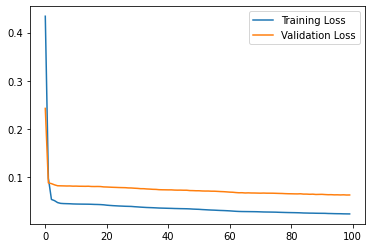

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

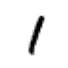

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(normal_test_data[1], cmap="binary")
plt.axis('off')
plt.show()

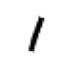

In [ ]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_data[1], cmap="binary")
plt.axis('off')
plt.show()

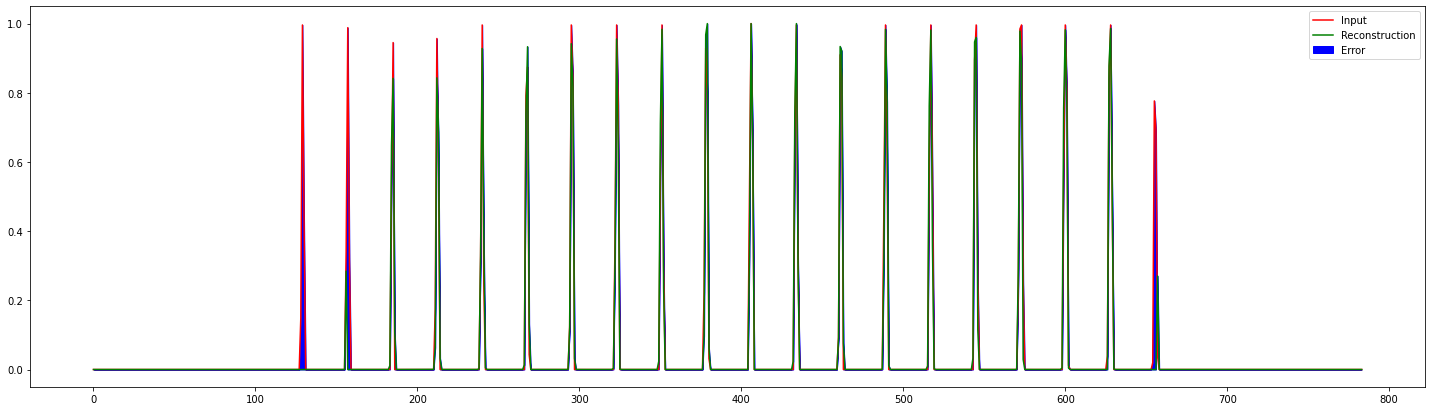

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(decoded_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

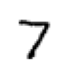

In [ ]:
encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(abnormal_test_data[0], cmap="binary")
plt.axis('off')
plt.show()

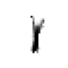

In [ ]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_abn_data[0], cmap="binary")
plt.axis('off')
plt.show()

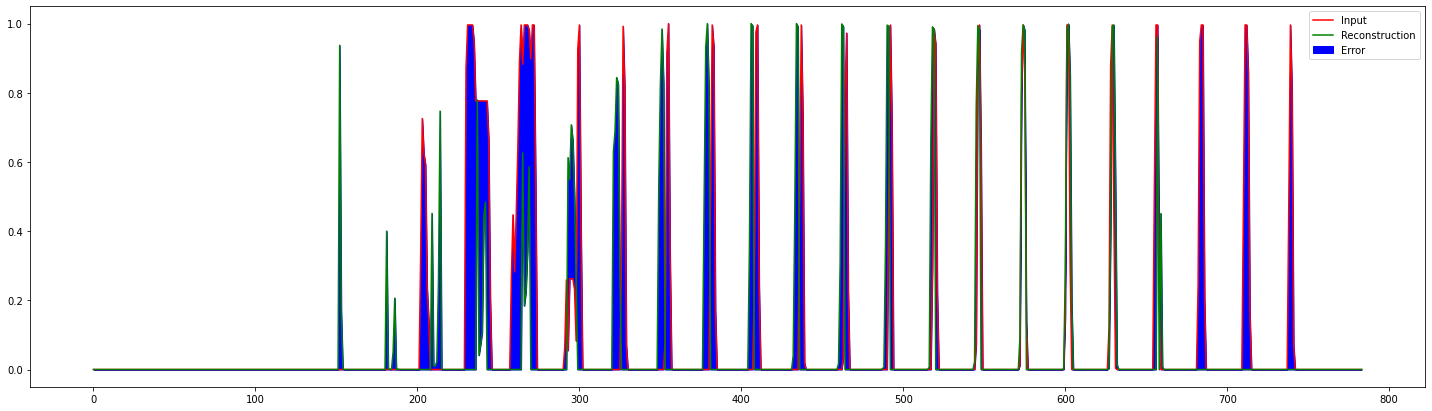

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(decoded_abn_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

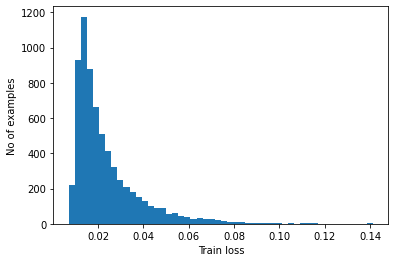

In [ ]:
reconstructions = autoencoder.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.038357135


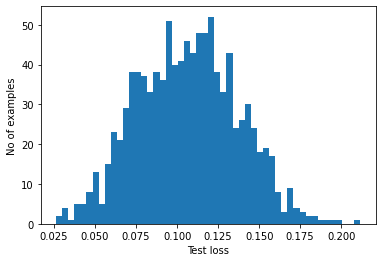

In [ ]:
reconstructions = autoencoder.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_test_data.reshape(-1,784))

plt.hist(abn_test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             1168   995
 label: F   [[1020   8]    1028
        T    [148   987]]   1135
Accuracy = 0.9278779472954231
Precision = 0.9919597989949749
Recall = 0.8696035242290749


In [ ]:
print(confusion_matrix(test_labels_T_F, preds))

[[1020    8]
 [ 148  987]]


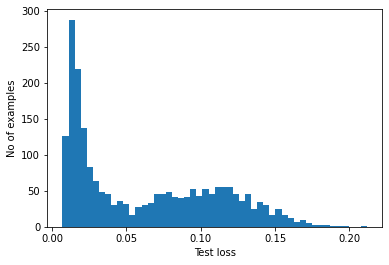

In [ ]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), test_data.reshape(-1,784))

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()